In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import minimize_scalar, minimize
from time import time
import seaborn as sns
import cvxpy as cxv
sns.set_style('darkgrid')
sns.set_context('notebook')
import sys
sys.path.append('..')

In [4]:
from osd import Problem
from osd.components import GaussNoise, SmoothFirstDifference, SparseFirstDiffConvex, Boolean, MarkovChain
from osd.utilities import progress
import cvxpy as cvx

In [5]:
from admm_helpers import markov_process_simulator, run_admm

# Convex example, $K=3$

In [6]:
def proj_l2_d0(data, theta=1, c=1):
    """Sum of squares"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(y) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d0(data, theta=1, c=1):
    """Sum of squares"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(y)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d1(data, theta=1, c=1):
    """Sum of absolute value of first difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(cvx.diff(y, k=1))) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d2(data, theta=1, c=1):
    """Sum of absolute value of second difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(cvx.diff(y, k=2))) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l2_d2(data, theta=1, c=1):
    """Sum of squares of second difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(cvx.diff(y, k=2)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l2_d1(data, theta=1, c=1):
    """Sum of squares of first difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(cvx.diff(y, k=1)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def make_data(length, points=None, shifts=None):
    if points is None:
        points = [0, int(length * 0.2), int(length * 0.55), int(length * 0.85), length]
    if shifts is None:
        shifts = [0, .5, -0.75, .2]
    cp = np.zeros(length)
    for ix, shft in enumerate(shifts):
        a = points[ix]
        b = points[ix + 1]
        cp[a:b] = shft
    return cp

/Users/bennetmeyers/miniconda3/envs/osd/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.


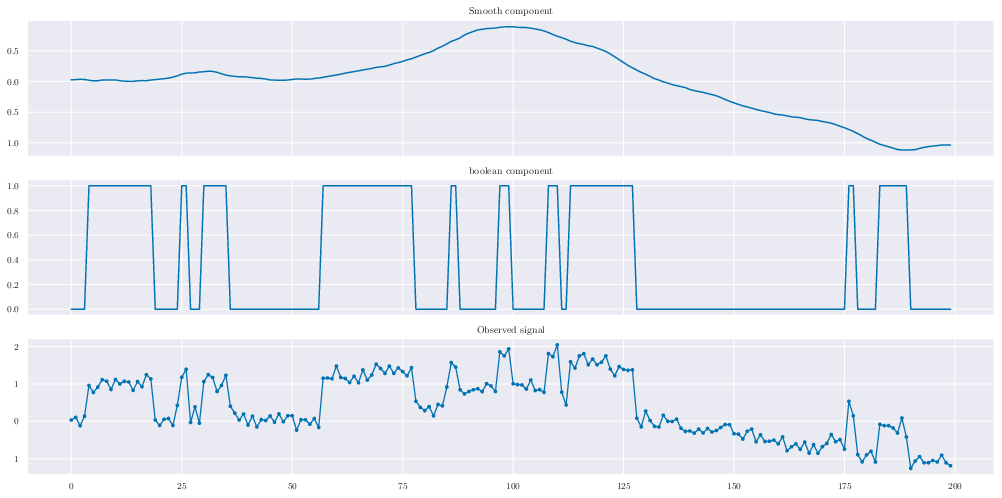

In [44]:
np.random.seed(4)
T = 200
X_real = np.zeros((3, T))
X_real[0] = 0.15 * np.random.randn(T)
X_real[1] = 5 * proj_l2_d1(np.random.randn(T), theta=3e2)
X_real[1] -= np.average(X_real[1])
X_real[2] = markov_process_simulator([[0.9, 0.1], [0.1, 0.9]], T=T, plot=False)
y = np.sum(X_real, axis=0)

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(14, 7))
ax[0].set_title('Smooth component')
ax[0].plot(X_real[1])
ax[1].set_title('boolean component')
ax[1].plot(X_real[2])
ax[2].set_title('Observed signal')
ax[2].plot(y, linewidth=1, marker='.')
# ax[2].plot(signal1 + signal2, label='true signal minus noise', ls='--')
plt.tight_layout()
plt.show()


In [45]:
c1 = GaussNoise()
c2 = SmoothFirstDifference(theta=10)
c3 = MarkovChain([[0.9, 0.1], [0.1, 0.9]], theta=.1)
components = [c1, c2, c3]

In [46]:
problem = Problem(y, components)

In [47]:
problem.decompose(admm=True, rho=1, num_iter=100)

[============================================================] 100.0% ...1.36 sec


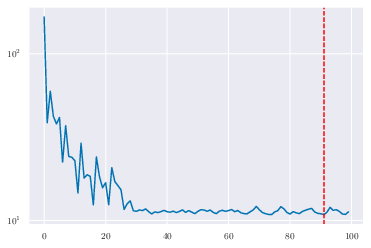

In [48]:
plt.plot(problem.admm_result['obj_vals'])
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.yscale('log')

In [49]:
import matplotlib
sns.set_context('paper')
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


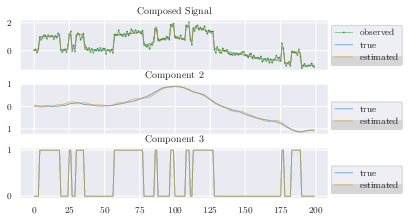

In [50]:
K = len(components)
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=(5.5,2.9))
for k in range(K):
    if k > 0:
        true = X_real[k]
        est = problem.estimates[k]
        ax[k].plot(true, label='true', linewidth=0.75, alpha=0.5)
        ax[k].plot(est, label='estimated', linewidth=0.75, alpha=0.5)
        ax[k].set_title('Component {}'.format(k+1))
    else:
        ax[k].plot(np.sum(X_real, axis=0), label='observed', linewidth=0.5, marker='.', color='green', ms=1, alpha=0.5)
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true', linewidth=0.75, alpha=0.5)
        ax[k].plot(np.sum(problem.estimates[1:], axis=0), label='estimated', linewidth=0.75, alpha=0.5)
        ax[k].set_title('Composed Signal')
    ax[k].legend(loc=[1.01, 0.1])
plt.tight_layout(pad=0.05)
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/simple-example.pgf')

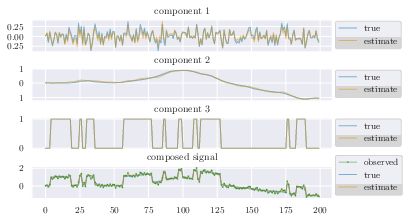

In [51]:
K = len(components)
fig, ax = plt.subplots(nrows=K+1, sharex=True, figsize=(5.5,2.9))
for k in range(K+1):
    if k <= K-1:
        ax[k].plot(X_real[k], linewidth=0.75, label='true', alpha=0.5)
        ax[k].plot(problem.estimates[k], label='estimate', linewidth=0.75, alpha=0.5)
        ax[k].set_title('component {}'.format(k+1))
    else:
        ax[k].plot(np.sum(X_real, axis=0),
                   label='observed', linewidth=0.5, marker='.', color='green', ms=1, alpha=0.5)
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true', linewidth=0.75, alpha=0.5)
        ax[k].plot(problem.estimates[1] + problem.estimates[2], label='estimate', 
                   linewidth=0.75, alpha=0.5)
        ax[k].set_title('composed signal')
    ax[k].legend(loc=[1.01, 0.1])
plt.tight_layout(pad=0.05)
fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/simple-example.pgf')

/Users/bennetmeyers/miniconda3/envs/osd/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


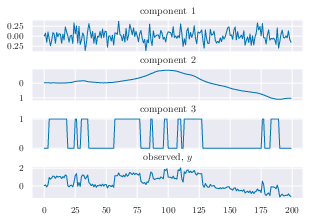

In [52]:
K = len(components)
fig, ax = plt.subplots(nrows=K+1, sharex=True, figsize=(5.5*.75,2.9))
for k in range(K+1):
    if k <= K-1:
        ax[k].plot(X_real[k], linewidth=0.75)
        ax[k].set_title('component {}'.format(k+1))
    else:
        ax[k].plot(np.sum(X_real, axis=0), linewidth=0.75)
        ax[k].set_title('observed, $y$')
plt.tight_layout(pad=0.05)
fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/example-components.pgf')
plt.show()

In [158]:
foo = np.array([
    [True, False, False, False, True],
    [False, True, True, False, False],
    [False, False, False, True, False],
])
np.argmax(foo, axis=0)

array([0, 1, 1, 2, 0])

# Non-convex ADMM

Solve the problem using the proximal operators of the signals classes. The algorithm first uses the L1-relaxation for a set number of iterations before switching to the non-convex set constraint.

In [33]:
switch_at = -1
run_noncvx = run_admm(y, num_iter=switch_at+100, rho=1, theta=1e4, switch_at=switch_at,
                      boolean_truth=signal2)
m1 = 'obj val:  {:.2f}'.format(run_noncvx['best_obj'])
m2 = 'num errs: {}'.format(run_noncvx['boolean_errors'][run_noncvx['it']])
m3 = 'best it:  {}'.format(run_noncvx['it'])
print('\n'.join([m1, m2, m3]))

[============================================================] 100.0% ...0.47 sec
obj val:  62.98
num errs: 38
best it:  37


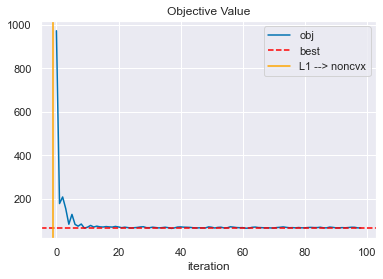

In [34]:
plt.plot(run_noncvx['obj_vals'], label='obj')
plt.axhline(run_noncvx['best_obj'], ls='--', color='red', label='best')
plt.axvline(switch_at, color='orange', label='L1 --> noncvx')
plt.legend()
plt.title('Objective Value')
plt.xlabel('iteration');
# plt.ylim(260, 400);
# plt.show()
# plt.plot(run_noncvx['relaxed_obj_vals'], label='obj')
# plt.axhline(run_noncvx['best_obj'], ls='--', color='red', label='best')
# plt.axvline(switch_at, color='orange', label='L1 --> noncvx')
# plt.legend()
# plt.title('Relaxed Objective Value')
# plt.xlabel('iteration');
# plt.ylim(260, 400);

best:  38 errors


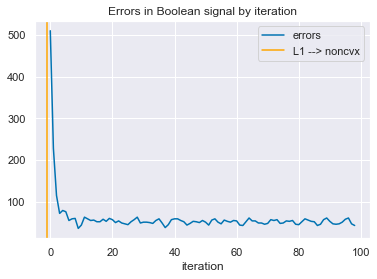

In [35]:
print('best: ', run_noncvx['boolean_errors'][run_noncvx['it']], 'errors')
plt.plot(run_noncvx['boolean_errors'], label='errors')
plt.axvline(switch_at, color='orange', label='L1 --> noncvx')
plt.legend()
plt.title('Errors in Boolean signal by iteration')
plt.xlabel('iteration');

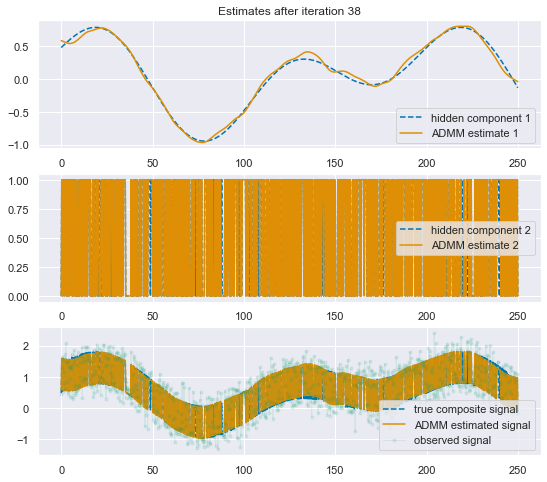

In [36]:
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
# ax[0].plot(t, problem.estimates[1], label='CVXPY estimate 1')
ax[0].plot(t, run_noncvx['x2'], label='ADMM estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
# ax[1].plot(t, problem.estimates[2], label='CVXPY estimate 2')
ax[1].plot(t, run_noncvx['x3'], label='ADMM estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
# ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='CVXPY estimated signal');
ax[2].plot(t, run_noncvx['x2'] + run_noncvx['x3'], label='ADMM estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()
ax[0].set_title('Estimates after iteration {}'.format(run_noncvx['it'] + 1));

In [11]:
for ix, estimate in enumerate(run_noncvx['boolean_estimates']):
    plt.figure(figsize=(8,6))
    plt.plot(signal2, ls='--', linewidth=1)
    plt.plot(estimate, linewidth=1)
    er = run_noncvx['boolean_errors'][ix]
    plt.title('{:.2f}% incorrect'.format(100 * er / len(signal2)))
    plt.savefig('save_figs/boolean_estimate_it_{:03}'.format(ix))
    plt.close(plt.gcf());

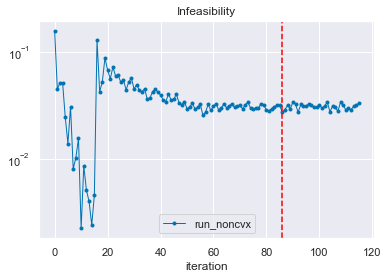

In [13]:
error = np.sum(problem.estimates, axis=0) - y
mse = np.sum(np.power(error, 2)) / error.size
r = np.linalg.norm(
    np.average(problem.estimates, axis=0) - y / 3
)
# plt.plot(run1['residuals'], label='run1')
# plt.plot(run2['residuals'], label='run2')
# plt.plot(run3['residuals'], label='run3')
plt.plot(run_noncvx['residuals'], label='run_noncvx', linewidth=1, marker='.')
# plt.axhline(mse, ls='--', color='red', label='cvxpy')
plt.axvline(run_noncvx['it'], ls='--', color='red')
plt.yscale('log')
plt.legend()
plt.title('Infeasibility')
plt.xlabel('iteration');

### Note! This table was generated from a different randomized data instance and results may not exacly match new instances

In [14]:
results_table = pd.read_csv('noncvx-admm-results-table_20210224.csv', index_col=0)

# rhos = np.logspace(-1, 1, 101)
# switch_points = np.round(np.logspace(-1, 6, 8, base=2))
# results_table = pd.DataFrame(columns=['sp', 'rho', 'min_obj'])
# # objective_values = []
# # objective_trends = []
# ix = 0
# total = len(rhos) * len(switch_points)
# ti = time()
# for sp in switch_points:
#     for r in rhos:
#         tn = time()
#         progress(ix, total, '{:.2f} minutes'.format((tn - ti) / 60))
#         run_noncvx = run_admm(y, num_iter=int(sp+100), rho=r, theta=1e6, switch_at=sp, verbose=False)
# #         objective_values.append(run_noncvx['best_obj'])
# #         objective_trends.append(run_noncvx['obj_vals'])
#         results_table.loc[ix] = [sp, r, run_noncvx['best_obj']]
#         ix += 1
# tn = time()
# progress(ix, total, '{:.2f} minutes'.format((tn - ti) / 60))
# results_table.to_csv('noncvx-admm-results-table_20210224.csv')

In [15]:
results_table

,sp,rho,min_obj
0,0.0,0.100000,102.694803
1,0.0,0.104713,102.362801
2,0.0,0.109648,103.075644
3,0.0,0.114815,103.014690
4,0.0,0.120226,103.240813
...,...,...,...
803,64.0,8.317638,136.431569
804,64.0,8.709636,136.883313
805,64.0,9.120108,139.349829
806,64.0,9.549926,141.128660


In [16]:
best_run = results_table.loc[np.argmin(results_table['min_obj'])]
best_run

sp         16.000000
rho         2.290868
min_obj    65.379606
Name: 573, dtype: float64

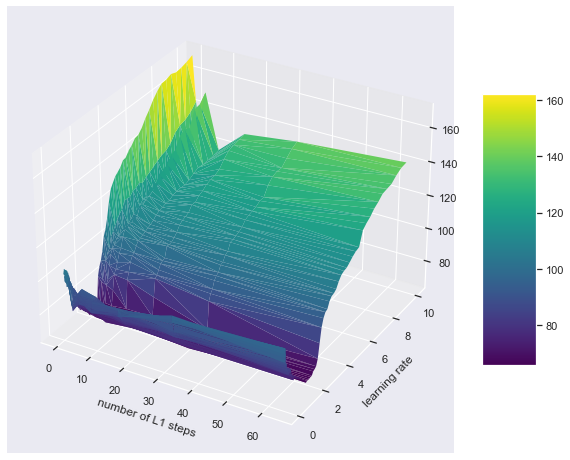

In [17]:
# Make the plot
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(results_table['sp'], results_table['rho'], results_table['min_obj'], cmap=plt.cm.viridis,
                     linewidth=0.001)

fig.colorbar( surf, shrink=0.5, aspect=5)
plt.xlabel('number of L1 steps')
plt.ylabel('learning rate')
plt.show()

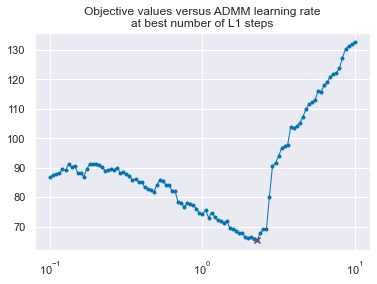

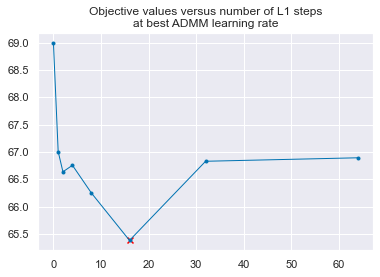

In [18]:
best_steps = results_table[np.isclose(results_table['sp'], best_run['sp'])]
best_rhos = results_table[np.isclose(results_table['rho'], best_run['rho'])]
plt.figure()
plt.title('Objective values versus ADMM learning rate\nat best number of L1 steps')
plt.plot(best_steps['rho'], best_steps['min_obj'], marker='.', linewidth=1)
plt.scatter(best_run['rho'], best_run['min_obj'], marker='x', color='red')
plt.xscale('log')
plt.show()
plt.figure()
plt.title('Objective values versus number of L1 steps\nat best ADMM learning rate')
plt.plot(best_rhos['sp'], best_rhos['min_obj'], marker='.', linewidth=1)
plt.scatter(best_run['sp'], best_run['min_obj'], marker='x', color='red')
# plt.xscale('log')
plt.show()

In [ ]:
thetas = np.logspace()